# Optimización de bobinas

En este notebook se estará desarrollando una propuesta para la optimización de la geometría de las bobinas del dispositivo SCR-1 ubicado en el Laboratorio de Plasmas para Energía de Fusión y Aplicaciones. Esto por medio de la caracterización de la geometría de las bobinas por medio de series de Fourier. Su optimización será basada en el cálculo de "errores", o desviaciones poloidales y radiales del campo magnético respecto a su componente toroidal. 


In [14]:
#Global modules
import numpy as np
import matplotlib.pyplot as plt

#Local Modules
from Rk4 import RK4
from read_coils import read_coil
from surfacefit import *
from propcalc import * 
from coord_transform import * 
from coil_parametrization import *


### Pseudocódigo 

1. Leer diseño inicial de bobinas.
2. Representar las bobinas matemáticamente por medio de parámetros.

    2.1 Escoger el modelo matemático a ajustar. 
    
    2.2 Minimizar una función de ajuste con los datos del archivo inicial.


3.  Generar una función que tome estos parámetros y calcule el campo magnético generado a partir de la representación matemática. 

4. A partir de esta función de campo, integrar la ecuación diferencial de línea de campo por el método de Runge-Kutta. 

5. Obtener los vectores normales para la superficie, y con esto realizar la operación respectiva para obtener el error local. 

6. Obtener un error promedio para poder tener una función escalar a minimizar dados los parámetros de las bobinas. 

7. Optimizar por medio de un algoritmo genético para obtener el nuevo set de parámetros de las bobinas. 

8. Repetir desde el paso 4. 

In [15]:
#Carga de datos de bobinas
data = read_coil('coils.txt')
data = np.transpose(data, axes=(0,2,1)) #ajuste de arreglo para funciones
data.shape

(12, 4, 361)

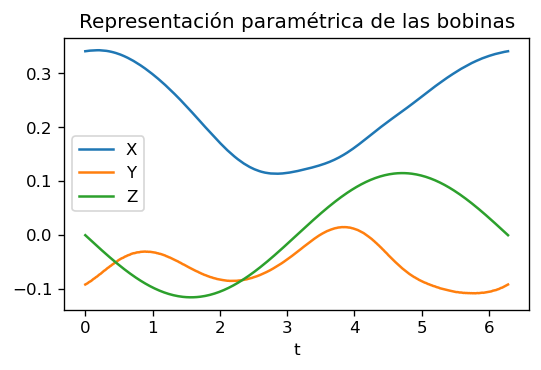

In [22]:
#visualización de las coordenadas de la bobina
m = 7 
x = data[2, 0,:]
y = data[2, 1,:]
z = data[2, 2,:]
cur = data[:,3, 0]
t = np.linspace(0,2*np.pi, num=len(x)) #cantidad de puntos paramétricos t

plt.figure(figsize=(5,3), dpi=120)
plt.plot(t,x, label='X')
plt.plot(t,y, label='Y')
plt.plot(t,z, label='Z')
plt.xlabel('t')
plt.legend()
plt.title('Representación paramétrica de las bobinas')
plt.show()

La representación del filamento de bobina se obtiene por medio del ajuste de cada coordenada espacial a una serie de Fourier de M términos dependiente de un parámetro $t \in [0,2\pi]$, de la siguiente manera, 

$$x^i = \sum_{m=0}^M A^i_m\cos(mt)+B^i_m\sin(mt) = C^i_{jk}X_{jk},$$

donde $i$ identifica a las coordenadas $(x^1, x^2, x^3) = (x,y,z)$, 

$$C^i_{jk} = \left(\begin{matrix}
A^i_{1} & A^i_{2}& \dots &A^i_{m} \\
B^i_{1} & B^i_{2}& \dots &B^i_{m}\\
\end{matrix}\right), $$

y 

$$X_{jk} = \left(\begin{matrix}
\cos(t) & \cos(2t)& \dots & \cos(mt) \\
\sin(t) & \sin(2t)& \dots & \sin(mt) \\
\end{matrix}\right), $$

Luego se toma este modelo y se aplica un error cuadrado medio como función a optimizar basados en los datos iniciales de las bobinas. Ver módulo ```coil_parametrization.py```.

In [25]:
k = 6
coefs, mat = parambobinas(data, k, t)

In [40]:
coefs.shape

(12, 3, 2, 7)

In [26]:
#Tranformación de los coeficientes de la serie de Fourier asociada.
X = cossin(t, k) 
param_data = coefstodata(coefs, X, cur)

El cálculo del campo magnético se desarrolla en el artículo "Compact expressions for the Biot–Savart fields of a filamentary segment" de James D. Hanson y Steven P. Hirshman, en el cual modelan un filamento continuo como elementos de línea discretos para desarrollar la ecuación de Biot-Savart y lograr llegar a la siguiente expresión para el campo, 

$$\textbf{B}=\frac{\mu_0I}{4\pi}\textbf{e}\times\textbf{R}_i\frac{2L(R_i+R_f)}{R_i R_f}\frac{1}{(R_i+R_f)^2-L^2}$$

Ya con este campo se pueden integrar las ecuaciones diferenciales de la línea de campo magnético definidas por: 

$$\frac{B}{dL} = \frac{B_x}{dx}= \frac{B_y}{dy}=\frac{B_z}{dz}$$

Para la integración de estas ecuaciones se utiliza el método de Runge-Kutta 4 con una implemetación "vectorial" esto aprovechando la  la capacidad de procesamiento de arreglos tipo ```np.array``` que tiene la librería  ```numpy```. Con esto la ecuación a integrar queda de la forma, 

$$\frac{d\textbf{r}}{|d\textbf{r}|}=\frac{\textbf{B}}{|\textbf{B}|}$$

Referirse a los módulos ```coil_biot.py``` y ```Rk4.py```.


In [27]:
#integracion de ecuacion de linea de campo 
tddata = np.transpose(param_data, axes=(0,2,1)) 
#ajuste de forma de datos para realizar la integración
init_pos = np.array([2.003334e-01,0.000000e+00,0.000000e+00])
linedata, _ = RK4(100, 100000, init_pos, tddata)

Para el cálculo de los errores los datos obtenidos por la integración se necesitan dar en coordenadas cilindrico-toroidales, y además se debe proporcionar el área de la superficie y este cálculo es hecho en coordenadas cílindricas, y al final una integración en coordenadas cartesianas. Por lo cual, es pertinente transformar los datos a estos sistemas. Referirse a módulo ```coord_transform.py```

In [29]:
areadata, errdata = carttotorcil(linedata, 0.2477)

El cálculo del área se basa en el manejo de arreglos que contienen las funciones base de la siguientes series,

$$S(\theta, \phi) = \sum_{m=0}^{M}\sum_{n=-N}^{N}P_{mn}\cos(m\theta-nN_{fp}\phi)$$,
$$S(\theta, \phi) = \sum_{m=0}^{M}\sum_{n=-N}^{N}P_{mn}\sin(m\theta-nN_{fp}\phi)$$, 
y, 
$$S(\theta, \phi) = \sum_{m=0}^{M}\sum_{n=-N}^{N}P_{mn}^{c}\cos(m\theta-nN_{fp}\phi)+P_{mn}^{s}\sin(m\theta-nN_{fp}\phi)$$

Tomando la primera serie como ejemplo estas series pueden ser definidas de la siguiente forma,

$$M = \left[\begin{matrix}
cos(0+nN_{fp}\phi) & \cos((n-1)N_{fp}\phi) & ... & \cos(-nN_{fp}\phi)\\
cos(\theta+nN_{fp}\phi) & \cos(\theta + (n-1)N_{fp}\phi) & ... & \cos(\theta-nN_{fp}\phi)\\
\vdots & \vdots & \ddots &\vdots\\
cos(m\theta+nN_{fp}\phi) & \cos(m\theta+(n-1)N_{fp}\phi) & ... & \cos(m\theta-nN_{fp}\phi)
\end{matrix}\right]$$

y el arreglo de parámetros $P_{mn}$,

$$P= \left[\begin{matrix}
P_{0,-n}& ... & P_{0,n}\\
P_{1,-n}& ... & P_{1,n}\\
\vdots  & \ddots &\vdots\\
P_{m,-n}& ... & P_{m,n}\\
\end{matrix}\right]$$

Se pueden definir las series anteriores de la siguiente manera, 

$$S_p = P^{ij}M_{ij}$$ 

Y de esta forma poder utilizar la función ```np.einsum()``` que es más eficiente a la hora de lidiar con diferentes tamaños de arreglos.


In [30]:
#Definición de parámetros de las ecuaciones anteriores
m = 15
n = 13
nfp = 2
num = 200 #dimensiones del espacio phi/tht para la integración

In [31]:
surfdata = initialize_data(areadata,80)

In [32]:
fitdata, fitmats, _ = data_setup(surfdata, m, n, nfp)
errs = errors(fitdata, fitmats, m, n)
coefs2 = optim_funcs(errs, m,n)
matts, vects, messh = matsmesh_setup(m,n, nfp, num)

Cálculo de vector normal:

La superficie $\Phi$ que se estudia está definida por la siguiente ecuación, 

$$\Phi(x,y,z) = R(\theta, \phi)\cos(\phi) \hat{x} + R(\theta, \phi)\cos(\phi) \hat{y} + Z(\theta, \phi)\hat{z}$$

El vector normal a esa superficie se puede definir en las coordenadas paramétricas $(\theta, \phi)$ como:

$$\textbf{n}=\frac{\partial\Phi}{\partial\theta}\times\frac{\partial\Phi}{\partial\phi}$$

Luego se puede definir el área de la superficie como,

$$A =\iint_\Omega \textbf{n}d\phi d\theta =\int_0^{2\pi}\int_0^{2\pi}\left|\frac{\partial\Phi}{\partial\theta}\times\frac{\partial\Phi}{\partial\phi}\right|d\phi d\theta$$

Referirse al módulo ```propcalc.py```. 

Para obtener los errores locales se toman las normales ya calculadas y se define, 

$$e_l = \frac{\textbf{B}·\textbf{n}}{|\textbf{B}|}$$

A partir de estos valores se obtiene el promedio, 

$$e_{prom} = \frac{1}{A}\int_{\Omega}{e_l dA}$$

$$A = \int_0^{2\pi}\int_0^{2\pi}\left|\frac{\partial\Phi}{\partial\theta}\times\frac{\partial\Phi}{\partial\phi}\right|d\phi d\theta$$

$$e_{prom} = \frac{1}{A}\int_0^{2\pi}\int_0^{2\pi}e_l\left|\frac{\partial\Phi}{\partial\theta}\times\frac{\partial\Phi}{\partial\phi}\right|d\phi d\theta$$

En este caso se utilizará una discretización de estas ecuaciones ya que el cálculo es mucho más rápido de esta manera. Referirse a ```errtorpath.py```.



In [34]:
area = normal_vector_area(coefs2[0], coefs2[1], num, nfp)
print('Área de superficie magnética: %.5f [m^2]' %area) 

Área de superficie magnética: 0.44727 [m^2]


In [35]:
_,_,_, *magfield = errdata.T
_, mats, mesh = data_setup(areadata.T, m, n, nfp)

In [38]:
import errtorpath as e
import imp
imp.reload(e)
popo = e.DatosFinales(errdata)
erloc = e.ErrorLocal(popo)
erprom = e.ErrorSup(erloc, area)

0.1968829734506627